# Análise de Dados Criminais

O objetivo dessa tarefa é construir um mapa do crime no Brasil a partir de dados abertos. O trabalho pode ser feito em dupla ou individual. Cada dupla ou pessoa deve fazer uma análise e pré-processamento dos dados para que possam construir um mapa do crime do Brasil. Além disso, vocês devem aplicar algoritmos de de clusterização para agrupar cidades de acordo com o nível de criminalidade (como o exemplo dos Estados Unidos que apresentei em sala de aula).

A base que vocês devem utilizar está disponível neste link:

http://dados.mj.gov.br/dataset/sistema-nacional-de-estatisticas-de-seguranca-publica

A base contém dados de crimes cometidos nos estados brasileiros. Na página vocês vão encontrar os dados por estado e por município. No entanto, para esse trabalho vamos usar apenas a base de estados. O nome do arquivo é `indicadoressegurancapublicauf.xlxs` e pode ser acessados no link acima onde tem **Dados Nacionais de Segurança Pública - UF**. No link também tem o arquivo **Dicionário de Dados - UF** que explica a tabela que vocês vão trabalhar. Além disso, o link contém outras informações relacionadas ao tema. Importante a leitura para ajudar na análise de vocês. 

O trabalho deve conter as seguintes tarefas

* pré-processamento e análise dos dados;
* aplicação dos algoritmos de clusterização e análise dos resultados;
* visualização dos resultados da análise e da clusterização. 

Para as etapas 1 e 3 vocês podem usar qualquer ferramenta: excel, power bi .... Para a etapa 2, utilizem os algoritmos de clusterização apresentados em sala de aula através da biblioteca **scikit-learn**. No material de aula mostro como construir uma tabela com os dados da clusterização. Essa saída pode ser usada nas ferramentas que vocês escolherem. Na etapa de clusterização vocês devem gerar o cluster e fazer a análise dos resultados. Variem parâmetros relacionados aos algoritmos de cluster para encontrar o melhor agrupamento. Essa análise deve ser feita também utilizando as métricas de avaliação não-supervisionadas vistas em sala de aula.

A seguir mostro como fazer a leitura do arquivo.

Bom trabalho ;) 

In [2]:
# Imports necessários
import pandas as pd
from sklearn import preprocessing
from scipy.spatial import distance_matrix
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as shc
import matplotlib.pyplot as plt
from sklearn.cluster import AgglomerativeClustering
import plotly.graph_objects as go

## Carregando a base do Excel 

O arquivo de entrar é um `.xlsx` que possui duas planilhas. A primeira com as ocorrências criminais e a segunda com o número de vítimas de diferentes registros criminais. Cada planilha foi salva em um DataFrame distinto. Vocês devem analisar a melhor forma de utilizar esses dados durante a etapa de pré-processamento ;) 

In [3]:
data_ocorrencias = pd.read_excel("indicadoressegurancapublicauf.xlsx",sheet_name='Ocorrências')

data_ocorrencias_original = data_ocorrencias

data_ocorrencias

,UF,Tipo Crime,Ano,Mês,Ocorrências
0,Acre,Estupro,2022,janeiro,31
1,Acre,Furto de veículo,2022,janeiro,50
2,Acre,Homicídio doloso,2022,janeiro,9
3,Acre,Lesão corporal seguida de morte,2022,janeiro,0
4,Acre,Roubo a instituição financeira,2022,janeiro,0
...,...,...,...,...,...
20441,Tocantins,Roubo a instituição financeira,2015,dezembro,6
20442,Tocantins,Roubo de carga,2015,dezembro,1
20443,Tocantins,Roubo de veículo,2015,dezembro,55
20444,Tocantins,Roubo seguido de morte (latrocínio),2015,dezembro,2


In [4]:
data_vitimas = pd.read_excel("indicadoressegurancapublicauf.xlsx",sheet_name='Vítimas')
data_vitimas

,UF,Tipo Crime,Ano,Mês,Sexo da Vítima,Vítimas
0,Acre,Homicídio doloso,2022,janeiro,Feminino,1
1,Acre,Homicídio doloso,2022,janeiro,Masculino,8
2,Acre,Homicídio doloso,2022,janeiro,Sexo NI,0
3,Acre,Lesão corporal seguida de morte,2022,janeiro,Feminino,0
4,Acre,Lesão corporal seguida de morte,2022,janeiro,Masculino,0
...,...,...,...,...,...,...
17430,Tocantins,Roubo seguido de morte (latrocínio),2015,junho,Masculino,1
17431,Tocantins,Roubo seguido de morte (latrocínio),2015,julho,Masculino,1
17432,Tocantins,Roubo seguido de morte (latrocínio),2015,agosto,Masculino,1
17433,Tocantins,Roubo seguido de morte (latrocínio),2015,outubro,Masculino,2


In [5]:
count_ = data_ocorrencias.count()
count_

UF             20446
Tipo Crime     20446
Ano            20446
Mês            20446
Ocorrências    20446
dtype: int64

In [6]:
count2_ = data_vitimas.count()
count2_

UF                17435
Tipo Crime        17435
Ano               17435
Mês               17435
Sexo da Vítima    17435
Vítimas           17435
dtype: int64

In [7]:
data_ocorrencias_original_uf_crime = data_ocorrencias_original.groupby(['UF','Tipo Crime','Ano']).sum()
data_ocorrencias_original_uf_crime

Ocorrências
UF        Tipo Crime             Ano              
Acre      Estupro                2015           42
                                 2016           36
                                 2017          108
                                 2018          260
                                 2019          330
...                                            ...
Tocantins Tentativa de homicídio 2018          417
                                 2019          518
                                 2020          442
                                 2021          359
                                 2022           33

[1914 rows x 1 columns]

Para iniciarmos o pré-processamento de dados, podemos alterar os dados categóricos "Sexo da vítima", "Mês", "UF" e "Tipo Crime" por um dado numérico.


In [8]:
df_ocorrencias_uf_crime = pd.read_excel("arquivos_gerados_pentaho/Ocorrências_UF_crime.xlsx",sheet_name='Ocorrências')
df_ocorrencias_uf_crime

,UF,Tipo Crime,Ocorrências
0,Acre,Estupro,1525
1,Acre,Furto de veículo,2769
2,Acre,Homicídio doloso,1971
3,Acre,Lesão corporal seguida de morte,8
4,Acre,Roubo a instituição financeira,13
...,...,...,...
238,Tocantins,Roubo a instituição financeira,93
239,Tocantins,Roubo de carga,41
240,Tocantins,Roubo de veículo,5160
241,Tocantins,Roubo seguido de morte (latrocínio),94


In [9]:
df_ocorrencias_uf_crime_ano = pd.read_excel("arquivos_gerados_pentaho/Ocorrências_UF_crime_ano.xlsx",sheet_name='Ocorrências')
df_ocorrencias_uf_crime_ano

,UF,Tipo Crime,Ano,Ocorrências
0,Acre,Estupro,2015,42
1,Acre,Estupro,2016,36
2,Acre,Estupro,2017,108
3,Acre,Estupro,2018,260
4,Acre,Estupro,2019,330
...,...,...,...,...
1909,Tocantins,Tentativa de homicídio,2018,417
1910,Tocantins,Tentativa de homicídio,2019,518
1911,Tocantins,Tentativa de homicídio,2020,442
1912,Tocantins,Tentativa de homicídio,2021,359


In [10]:
df_ocorrencias_uf_crime_ano_mes = pd.read_excel("arquivos_gerados_pentaho/Ocorrências_UF_crime_ano_mes.xlsx",sheet_name='Ocorrências')
df_ocorrencias_uf_crime_ano_mes

,UF,Tipo Crime,Ano,Mês,Ocorrências
0,Acre,Estupro,2015,abril,3
1,Acre,Estupro,2015,agosto,1
2,Acre,Estupro,2015,dezembro,0
3,Acre,Estupro,2015,fevereiro,8
4,Acre,Estupro,2015,janeiro,6
...,...,...,...,...,...
20441,Tocantins,Tentativa de homicídio,2021,março,29
20442,Tocantins,Tentativa de homicídio,2021,novembro,19
20443,Tocantins,Tentativa de homicídio,2021,outubro,35
20444,Tocantins,Tentativa de homicídio,2021,setembro,26


In [11]:
df_ocorrencias_uf_crime_mes = pd.read_excel("arquivos_gerados_pentaho/Ocorrências_UF_crime_mes.xlsx",sheet_name='Ocorrências')
df_ocorrencias_uf_crime_mes

,UF,Tipo Crime,Mês,Ocorrências
0,Acre,Estupro,abril,130
1,Acre,Estupro,agosto,143
2,Acre,Estupro,dezembro,117
3,Acre,Estupro,fevereiro,94
4,Acre,Estupro,janeiro,142
...,...,...,...,...
2911,Tocantins,Tentativa de homicídio,maio,254
2912,Tocantins,Tentativa de homicídio,março,186
2913,Tocantins,Tentativa de homicídio,novembro,247
2914,Tocantins,Tentativa de homicídio,outubro,285


In [12]:
df_vitimas_uf_crime_sexo = pd.read_excel("arquivos_gerados_pentaho/Vítimas_UF_crime_sexo.xlsx",sheet_name='Ocorrências')
df_vitimas_uf_crime_sexo

,UF,Tipo Crime,Sexo da Vítima,Vítimas
0,Acre,Homicídio doloso,Feminino,164
1,Acre,Homicídio doloso,Masculino,1739
2,Acre,Homicídio doloso,Sexo NI,16
3,Acre,Lesão corporal seguida de morte,Feminino,2
4,Acre,Lesão corporal seguida de morte,Masculino,5
...,...,...,...,...
238,Tocantins,Lesão corporal seguida de morte,Masculino,38
239,Tocantins,Lesão corporal seguida de morte,Sexo NI,0
240,Tocantins,Roubo seguido de morte (latrocínio),Feminino,16
241,Tocantins,Roubo seguido de morte (latrocínio),Masculino,92


In [13]:
df_vitimas_uf_crime_sexo_ano = pd.read_excel("arquivos_gerados_pentaho/Vítimas_UF_crime_sexo_ano.xlsx",sheet_name='Ocorrências')
df_vitimas_uf_crime_sexo_ano

,UF,Tipo Crime,Sexo da Vítima,Ano,Vítimas
0,Acre,Homicídio doloso,Feminino,2015,15
1,Acre,Homicídio doloso,Feminino,2016,20
2,Acre,Homicídio doloso,Feminino,2017,20
3,Acre,Homicídio doloso,Feminino,2018,30
4,Acre,Homicídio doloso,Feminino,2019,30
...,...,...,...,...,...
1822,Tocantins,Roubo seguido de morte (latrocínio),Masculino,2022,1
1823,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,2019,0
1824,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,2020,0
1825,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,2021,0


In [14]:
df_vitimas_uf_crime_sexo_ano_mes = pd.read_excel("arquivos_gerados_pentaho/Vítimas_UF_crime_sexo_ano_mes.xlsx",sheet_name='Ocorrências')
df_vitimas_uf_crime_sexo_ano_mes

,UF,Tipo Crime,Sexo da Vítima,Ano,Mês,Vítimas
0,Acre,Homicídio doloso,Feminino,2015,abril,0
1,Acre,Homicídio doloso,Feminino,2015,agosto,0
2,Acre,Homicídio doloso,Feminino,2015,dezembro,1
3,Acre,Homicídio doloso,Feminino,2015,fevereiro,1
4,Acre,Homicídio doloso,Feminino,2015,janeiro,2
...,...,...,...,...,...,...
17430,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,2021,maio,0
17431,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,2021,novembro,0
17432,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,2021,outubro,0
17433,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,2021,setembro,0


In [15]:
df_vitimas_uf_crime_sexo_mes = pd.read_excel("arquivos_gerados_pentaho/Vítimas_UF_crime_sexo_mes.xlsx",sheet_name='Ocorrências')
df_vitimas_uf_crime_sexo_mes

,UF,Tipo Crime,Sexo da Vítima,Mês,Vítimas
0,Acre,Homicídio doloso,Feminino,abril,13
1,Acre,Homicídio doloso,Feminino,agosto,11
2,Acre,Homicídio doloso,Feminino,dezembro,10
3,Acre,Homicídio doloso,Feminino,fevereiro,18
4,Acre,Homicídio doloso,Feminino,janeiro,22
...,...,...,...,...,...
2905,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,junho,0
2906,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,maio,0
2907,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,novembro,0
2908,Tocantins,Roubo seguido de morte (latrocínio),Sexo NI,outubro,0


In [42]:
data_vitimas = pd.get_dummies(data_vitimas, columns=["Sexo da Vítima","Mês","Tipo Crime"])
data_vitimas.head()


,UF,Ano,Vítimas,Sexo da Vítima_Feminino,Sexo da Vítima_Masculino,Sexo da Vítima_Sexo NI,Mês_abril,Mês_agosto,Mês_dezembro,Mês_fevereiro,...,Mês_julho,Mês_junho,Mês_maio,Mês_março,Mês_novembro,Mês_outubro,Mês_setembro,Tipo Crime_Homicídio doloso,Tipo Crime_Lesão corporal seguida de morte,Tipo Crime_Roubo seguido de morte (latrocínio)
0,Acre,2022,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Acre,2022,8,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,Acre,2022,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,Acre,2022,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Acre,2022,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


Devemos fazer uma transformação similar para o dataset relativo a ocorrências também. Neste caso, transformaremos as colunas "UF", "Tipo Crime" e "Mês".

In [43]:
data_ocorrencias = pd.get_dummies(data_ocorrencias, columns=["UF", "Tipo Crime", "Mês"])
data_ocorrencias

,Ano,Ocorrências,UF_Acre,UF_Alagoas,UF_Amapá,UF_Amazonas,UF_Bahia,UF_Ceará,UF_Distrito Federal,UF_Espírito Santo,...,Mês_dezembro,Mês_fevereiro,Mês_janeiro,Mês_julho,Mês_junho,Mês_maio,Mês_março,Mês_novembro,Mês_outubro,Mês_setembro
0,2022,31,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2022,50,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2022,9,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2022,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2022,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20441,2015,6,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20442,2015,1,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20443,2015,55,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
20444,2015,2,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0


In [44]:
meses = [x for x in data_vitimas.columns.values if x[:3] == 'Mês']

tipo_crime = [x for x in data_vitimas.columns.values if x[:2] == 'Ti']

In [45]:
1# Esta parte agrupa as unidades federativas em regiões
regioes = {'Norte' : ['Acre', 'Amazonas', 'Amapá', 'Pará', 'Rondônia', 'Roraima', 'Tocantins'], 
           'Nordeste' : ['Alagoas', 'Bahia', 'Ceará', 'Maranhão', 'Piauí', 'Pernambuco', 'Paraíba', 'Rio Grande do Norte', 'Sergipe'], 
           'Centro-Oeste' : ['Goiás', 'Mato Grosso', 'Mato Grosso do Sul', 'Distrito Federal'], 
           'Sudeste' : ['Espírito Santo', 'Minas Gerais', 'Rio de Janeiro', 'São Paulo'], 
           'Sul' : ['Paraná', 'Rio Grande do Sul', 'Santa Catarina']
           }
regs = []
for row in data_vitimas.index:
  for reg, ufs in regioes.items():
    if data_vitimas['UF'][row] in ufs:
      regs.append(reg)

data_vitimas['Região'] = regs
data_vitimas

,UF,Ano,Vítimas,Sexo da Vítima_Feminino,Sexo da Vítima_Masculino,Sexo da Vítima_Sexo NI,Mês_abril,Mês_agosto,Mês_dezembro,Mês_fevereiro,...,Mês_junho,Mês_maio,Mês_março,Mês_novembro,Mês_outubro,Mês_setembro,Tipo Crime_Homicídio doloso,Tipo Crime_Lesão corporal seguida de morte,Tipo Crime_Roubo seguido de morte (latrocínio),Região
0,Acre,2022,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Norte
1,Acre,2022,8,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Norte
2,Acre,2022,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,1,0,0,Norte
3,Acre,2022,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Norte
4,Acre,2022,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,Norte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17430,Tocantins,2015,1,0,1,0,0,0,0,0,...,1,0,0,0,0,0,0,0,1,Norte
17431,Tocantins,2015,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,Norte
17432,Tocantins,2015,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,Norte
17433,Tocantins,2015,2,0,1,0,0,0,0,0,...,0,0,0,0,1,0,0,0,1,Norte


In [46]:
data_vitimas = pd.get_dummies(data_vitimas, columns=["Região"])
data_vitimas.head()

,UF,Ano,Vítimas,Sexo da Vítima_Feminino,Sexo da Vítima_Masculino,Sexo da Vítima_Sexo NI,Mês_abril,Mês_agosto,Mês_dezembro,Mês_fevereiro,...,Mês_outubro,Mês_setembro,Tipo Crime_Homicídio doloso,Tipo Crime_Lesão corporal seguida de morte,Tipo Crime_Roubo seguido de morte (latrocínio),Região_Centro-Oeste,Região_Nordeste,Região_Norte,Região_Sudeste,Região_Sul
0,Acre,2022,1,1,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,Acre,2022,8,0,1,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
2,Acre,2022,0,0,0,1,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
3,Acre,2022,0,1,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,Acre,2022,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,0


<AxesSubplot:>

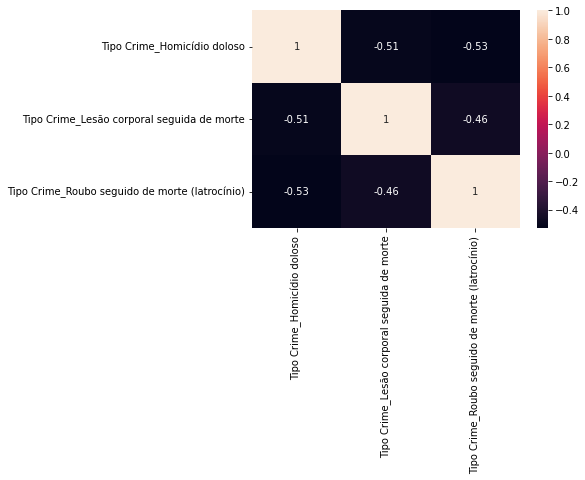

In [47]:
dataset_data_vitimas_corr_crimes = data_vitimas[tipo_crime].corr()
dataset_data_vitimas_corr_crimes
sns.heatmap(dataset_data_vitimas_corr_crimes , xticklabels=list(tipo_crime), yticklabels=list(tipo_crime), annot=True)

In [48]:
regioes_lista = [x for x in data_vitimas.columns.values if x[:4] == 'Regi']
regioes_lista

['Região_Centro-Oeste',
 'Região_Nordeste',
 'Região_Norte',
 'Região_Sudeste',
 'Região_Sul']

In [49]:
crimes_regioes = tipo_crime + regioes_lista
crimes_regioes

['Tipo Crime_Homicídio doloso',
 'Tipo Crime_Lesão corporal seguida de morte',
 'Tipo Crime_Roubo seguido de morte (latrocínio)',
 'Região_Centro-Oeste',
 'Região_Nordeste',
 'Região_Norte',
 'Região_Sudeste',
 'Região_Sul']

In [50]:
dataset_data_vitimas_corr = data_vitimas[crimes_regioes].corr()
dataset_data_vitimas_corr

,Tipo Crime_Homicídio doloso,Tipo Crime_Lesão corporal seguida de morte,Tipo Crime_Roubo seguido de morte (latrocínio),Região_Centro-Oeste,Região_Nordeste,Região_Norte,Região_Sudeste,Região_Sul
Tipo Crime_Homicídio doloso,1.000000,-0.508102,-0.528016,-0.000519,-0.018466,0.047820,-0.014467,-0.018486
Tipo Crime_Lesão corporal seguida de morte,-0.508102,1.000000,-0.463156,-0.007594,0.012970,-0.029646,0.010964,0.015844
Tipo Crime_Roubo seguido de morte (latrocínio),-0.528016,-0.463156,1.000000,0.008022,0.006213,-0.019975,0.004076,0.003400
Região_Centro-Oeste,-0.000519,-0.007594,0.008022,1.000000,-0.311833,-0.229226,-0.180258,-0.149553
Região_Nordeste,-0.018466,0.012970,0.006213,-0.311833,1.000000,-0.402924,-0.316849,-0.262877
Região_Norte,0.047820,-0.029646,-0.019975,-0.229226,-0.402924,1.000000,-0.232913,-0.193239
Região_Sudeste,-0.014467,0.010964,0.004076,-0.180258,-0.316849,-0.232913,1.000000,-0.151958
Região_Sul,-0.018486,0.015844,0.003400,-0.149553,-0.262877,-0.193239,-0.151958,1.000000


<AxesSubplot:>

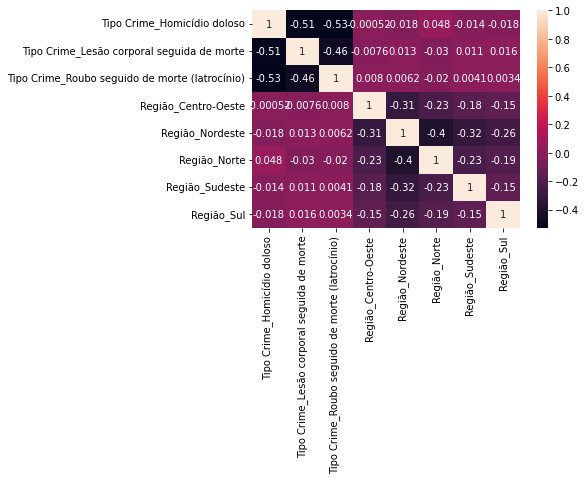

In [51]:
sns.heatmap(dataset_data_vitimas_corr , xticklabels=list(crimes_regioes), yticklabels=list(crimes_regioes), annot=True)

In [52]:
data_ocorrencias.head()

,Ano,Ocorrências,UF_Acre,UF_Alagoas,UF_Amapá,UF_Amazonas,UF_Bahia,UF_Ceará,UF_Distrito Federal,UF_Espírito Santo,...,Mês_dezembro,Mês_fevereiro,Mês_janeiro,Mês_julho,Mês_junho,Mês_maio,Mês_março,Mês_novembro,Mês_outubro,Mês_setembro
0,2022,31,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,2022,50,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
2,2022,9,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
3,2022,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
4,2022,0,1,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [65]:
data_ocorrencias_original_uf_crime

Ocorrências
UF        Tipo Crime             Ano              
Acre      Estupro                2015           42
                                 2016           36
                                 2017          108
                                 2018          260
                                 2019          330
...                                            ...
Tocantins Tentativa de homicídio 2018          417
                                 2019          518
                                 2020          442
                                 2021          359
                                 2022           33

[1914 rows x 1 columns]

In [ ]:
tipos_crimes = data_ocorrencias_original_uf_crime['Tipo Crime']

In [57]:
ocorrencias = [x for x in data_ocorrencias.columns.values if x[:4] == 'Tipo']
ocorrencias

['Tipo Crime_Estupro',
 'Tipo Crime_Furto de veículo',
 'Tipo Crime_Homicídio doloso',
 'Tipo Crime_Lesão corporal seguida de morte',
 'Tipo Crime_Roubo a instituição financeira',
 'Tipo Crime_Roubo de carga',
 'Tipo Crime_Roubo de veículo',
 'Tipo Crime_Roubo seguido de morte (latrocínio)',
 'Tipo Crime_Tentativa de homicídio']

In [59]:
dataset_data_ocorrencias_corr = data_ocorrencias[ocorrencias].corr()
dataset_data_ocorrencias_corr

,Tipo Crime_Estupro,Tipo Crime_Furto de veículo,Tipo Crime_Homicídio doloso,Tipo Crime_Lesão corporal seguida de morte,Tipo Crime_Roubo a instituição financeira,Tipo Crime_Roubo de carga,Tipo Crime_Roubo de veículo,Tipo Crime_Roubo seguido de morte (latrocínio),Tipo Crime_Tentativa de homicídio
Tipo Crime_Estupro,1.000000,-0.125974,-0.126067,-0.125353,-0.124513,-0.123293,-0.125974,-0.125974,-0.125912
Tipo Crime_Furto de veículo,-0.125974,1.000000,-0.126160,-0.125446,-0.124605,-0.123384,-0.126067,-0.126067,-0.126005
Tipo Crime_Homicídio doloso,-0.126067,-0.126160,1.000000,-0.125539,-0.124697,-0.123475,-0.126160,-0.126160,-0.126098
Tipo Crime_Lesão corporal seguida de morte,-0.125353,-0.125446,-0.125539,1.000000,-0.123991,-0.122777,-0.125446,-0.125446,-0.125384
Tipo Crime_Roubo a instituição financeira,-0.124513,-0.124605,-0.124697,-0.123991,1.000000,-0.121953,-0.124605,-0.124605,-0.124544
Tipo Crime_Roubo de carga,-0.123293,-0.123384,-0.123475,-0.122777,-0.121953,1.000000,-0.123384,-0.123384,-0.123324
Tipo Crime_Roubo de veículo,-0.125974,-0.126067,-0.126160,-0.125446,-0.124605,-0.123384,1.000000,-0.126067,-0.126005
Tipo Crime_Roubo seguido de morte (latrocínio),-0.125974,-0.126067,-0.126160,-0.125446,-0.124605,-0.123384,-0.126067,1.000000,-0.126005
Tipo Crime_Tentativa de homicídio,-0.125912,-0.126005,-0.126098,-0.125384,-0.124544,-0.123324,-0.126005,-0.126005,1.000000


<AxesSubplot:>

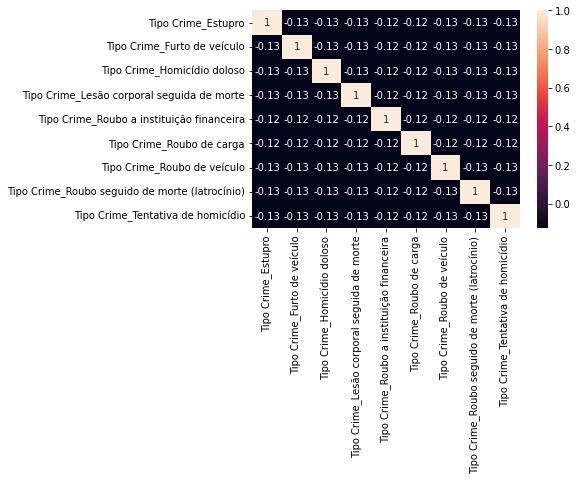

In [58]:
sns.heatmap(dataset_data_ocorrencias_corr , xticklabels=ocorrencias, yticklabels=ocorrencias, annot=True)